In [47]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("./tools/")

%matplotlib inline
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy

from pprint import pprint
import operator

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Data Exploration & Feature Processing

Dataset is first loaded into dictionary. Subsequently, data is explored (no. of persons in dataset, features with/without useful information, visualisation of features etc.) with the goal of understanding the data better and selecting the optimal features to use for training the algorithm.

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
# Structure of dataset (print out a key, value pair from data_dict)
print "The general structure of the dataset is as follows:\n"
print (data_dict.items()[0])
print "\n"

### Key Information

# Removing outlier (Udacity requirement - Task 2)
# During some preliminary analysis and data visualisation, an unnecessary data point, "TOTAL", was found to be 
# present. As this is actually a sum of all other persons in dataset, its not useful here and is removed.
data_dict.pop('TOTAL', None)

# No. of persons in dataest
print "Total number of persons in dataset:", len(data_dict), "\n"

The general structure of the dataset is as follows:

('METTS MARK', {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38})


Total number of persons in dataset: 145 



In [4]:
# Find how many data pts are available for each feature. 
# Since there are 145 persons in total, the max number of data pts possible for a feature is 145. 
# If number is too low (ie. feature is mostly NaN), it would probably not be ideal to use that feature for training.

available_features_list = (data_dict.items()[0][1]).keys()
feature_count = {}

for feature in available_features_list:
    count = 0
    for values in data_dict.values():
        if values[feature] != "NaN":
            count += 1
    feature_count[feature] = count

sorted_feature_count = sorted(feature_count.items(), key=operator.itemgetter(1), reverse=True)

print "No. of data pts available for each features (descending order):\n"
print (sorted_feature_count)

No. of data pts available for each features (descending order):

[('poi', 145), ('total_stock_value', 125), ('total_payments', 124), ('email_address', 111), ('restricted_stock', 109), ('exercised_stock_options', 101), ('salary', 94), ('expenses', 94), ('other', 92), ('to_messages', 86), ('shared_receipt_with_poi', 86), ('from_messages', 86), ('from_poi_to_this_person', 86), ('from_this_person_to_poi', 86), ('bonus', 81), ('long_term_incentive', 65), ('deferred_income', 48), ('deferral_payments', 38), ('restricted_stock_deferred', 17), ('director_fees', 16), ('loan_advances', 3)]


Using some logical intuition, the following was done:
- any feature for which less than half the total no. of persons had data, was removed from consideration
- "email_address", "other" features were removed as they aren't too useful
- "poi" removed since its used as label

Resulting list shown below are the features to be considered for training.

In [5]:
cleaned_feature_list = []

for element in sorted_feature_count:
    if element[1]>=(145/2) and element[0]!="poi" and element[0]!="email_address" and element[0]!="other":
        cleaned_feature_list.append(element[0])

print cleaned_feature_list
print len(cleaned_feature_list), "features"

['total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus']
12 features


<h3>Creating/processing new features</h3>

As part of Udacity's requirements for the final project, new features were to be implemented based on the understanding of the data, and its strength compared to other features had to be considered when selecting features for training the final algoritm.

The email features were explored for this requirement and new features were implemented as shown below.

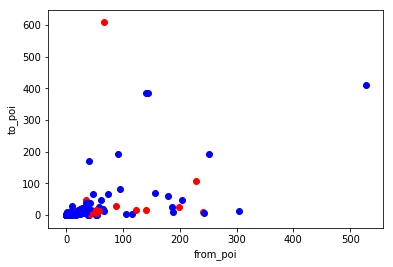

In [6]:
# Initial visualization of email features to identify possible trends

for key, value in data_dict.items():
    from_poi = value["from_poi_to_this_person"]
    to_poi = value["from_this_person_to_poi"]
    if value["poi"]==1:
        plt.scatter(from_poi, to_poi, color="r")
    if value["poi"]==0:
        plt.scatter(from_poi, to_poi, color="b")

plt.xlabel("from_poi")
plt.ylabel("to_poi")

plt.show()

In addition to not displaying any strong trend, this plot is not exactly a good representation of the features across the persons as the data points are not normalised to the number of emails sent or received by each person. 

Consequently, for each person, the fraction of emails sent/received that were to/from POI was calculated and then added to dataset. The data was also visualised as shown below.

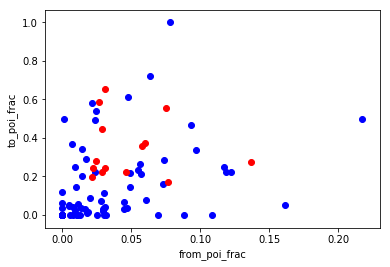

In [7]:
def compute_fraction(A,B):
    if A == "NaN" or B == "NaN":
        return 0

    return (1.0*A)/B

for key, value in data_dict.items():
    # compute fraction
    from_poi_frac = compute_fraction(value["from_poi_to_this_person"], value["to_messages"])
    to_poi_frac = compute_fraction(value["from_this_person_to_poi"], value["from_messages"])
    
    # store in data_dict
    value["from_poi_frac"] = from_poi_frac
    value["to_poi_frac"] = to_poi_frac
    
    if value["poi"]==1:
        plt.scatter(from_poi_frac, to_poi_frac, color="r")
    if value["poi"]==0:
        plt.scatter(from_poi_frac, to_poi_frac, color="b")
    
plt.xlabel("from_poi_frac")
plt.ylabel("to_poi_frac")
plt.show()

While no significant trend was seen, the red points (poi) and blue points (non-poi) are slightly more distinctly separated into clusters which could potentially contribute to training the algorithm. The effect/importance of each feature including these are examined later.

As such, the new list of features to consider would be as follows:

In [8]:
cleaned_feature_list.remove("from_poi_to_this_person")
cleaned_feature_list.remove("to_messages")
cleaned_feature_list.remove("from_this_person_to_poi")
cleaned_feature_list.remove("from_messages")

cleaned_feature_list.append("from_poi_frac")
cleaned_feature_list.append("to_poi_frac")

print cleaned_feature_list
print "Total:", len(cleaned_feature_list), "features"

# New features created are part of the feature list as seen below (Udacity requirement - Task 3)

['total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'shared_receipt_with_poi', 'bonus', 'from_poi_frac', 'to_poi_frac']
Total: 10 features


<h3>Feature selection</h3>

With the 10 features to be considered for training, the next step was to figure out whether to use all 10 features for training, or just a subset and if the latter, which features to select. 

To find the optimal selection, 8 different selections of features were made using sklearn's feature selection tool where k took on values from 3-10. k refers to the parameter in SelectKBest function, which selects the best k features from a given list of features. So, after the loop was run, there were 8 sets of features with the first set having the best 3 features, next having best 4 features and so on till the 8th set which had all 10 features. Within each these feature selections, the data was split into training and test data. 

In the next section, "Algorithms", different algos were trained using the training data and then evaluated using the test data for each of the 8 feature sets. In this way, it was possible to simultaneously identify the best selection of features as well as the best training algorithm. 

In [9]:
# feature_list below is input for Udacity's starter code.
# It is a list of strings, each of which is a feature name. The first feature must be "poi" (label).

features_list = ['poi','salary', 'bonus', 'total_stock_value', 'total_payments', 'restricted_stock', \
                 'exercised_stock_options', 'expenses', 'shared_receipt_with_poi', 'from_poi_frac', 'to_poi_frac']


# Store to "my_dataset" for easy export below. "my_dataset" is input for Udacity's starter code.
my_dataset = data_dict


# featureFormat, targetFeatureSplit are functions from Udacity's starter code. As mentioned under Project Requirements
# (in README.md), these functions take in the dataset and the features chosen, and puts them into a numpy array 
# suitable for input for sklearn functions. 

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [10]:
# Loop to create all 8 features sets ie. k = 3,4,5...10
from sklearn.feature_selection import SelectKBest, f_classif

new_features_list = []
feature_score_dict = {}

for i in range(3,11):
    
    selector = SelectKBest(f_classif, k=i)
    selector.fit(features, labels)

    new_features = selector.transform(features)
    
    new_features_list.append(new_features)
    
    # To create a reverse sorted list of tuples of format, (feature, score), to identify the features being used in
    # the various algos later.
    if i==10:
        scores = selector.scores_
        features_list.pop(0)
        
        for j in range(len(scores)):
            feature_score_dict[features_list[j]] = scores[j]
        
        feature_score_tup_sorted = sorted(feature_score_dict.items(), key=operator.itemgetter(1), reverse=True)

In [11]:
# For each feature set, create training + test features and training + test labels
# They are stored in separate lists for easy traversal during training

from sklearn.model_selection import train_test_split

features_train_list = []
features_test_list = []
labels_train_list = []
labels_test_list = []

for features in new_features_list:
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
    features_train_list.append(features_train)
    features_test_list.append(features_test)
    labels_train_list.append(labels_train)
    labels_test_list.append(labels_test)


In [12]:
# For reference and checking

print "No of sets of training features:", len(features_train_list), "\n"
print "No. of features in each data point in 1st set:", len(features_train_list[0][0])
print "1st set, 1st data point:", features_train_list[0][0], "\n"
print "No. of features in each data point in last set:", len(features_train_list[7][0])
print "last set, 1st data point:", features_train_list[7][0]

No of sets of training features: 8 

No. of features in each data point in 1st set: 3
1st set, 1st data point: [ 800000.  495633.  117551.] 

No. of features in each data point in last set: 10
last set, 1st data point: [  3.14288000e+05   8.00000000e+05   4.95633000e+05   1.10139300e+06
   3.78082000e+05   1.17551000e+05   2.78610000e+04   7.10000000e+01
   0.00000000e+00   1.21212121e-01]


# Algorithms

<h3>Common Functions</h3>

In [13]:
# Function for evaluation of algo. 
# Evaluation is primarily based on precicision score and recall score.
# Function will print "Accept" if both scores are above 0.3 (udacity's requirement)

def evaluate(labels_test, pred):
    acc = accuracy_score(labels_test, pred)
    ps = precision_score(labels_test, pred)
    rs = recall_score(labels_test, pred)

    print "acc:", acc
    print "precision_score:", ps
    print "recall_score:", rs

    # Evaluation criteria
    print "\n"
    if ps < 0.3 or rs < 0.3:
        print "Reject, precision and/or recall score < 0.3"
    else:
        print "Accept"

<h3>Decision Tree</h3>

In [14]:
# The decision tree algo was run for each of the set of features. Within each, the paramaters are tuned and optimized
# using GridSearchCV. All output is shown below.

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

for i in range(len(features_train_list)):
    params = {'min_samples_split':[2,3,4,5,6,7,8,9,10], 'criterion':('gini', 'entropy')}
    clf_tree = tree.DecisionTreeClassifier()
    clf = GridSearchCV(clf_tree, params)
    
    features_train = features_train_list[i]
    features_test = features_test_list[i]
    labels_train = labels_train_list[i]
    labels_test = labels_test_list[i]

    clf.fit(features_train, labels_train)

    print "parameters:", clf.best_params_

    pred = clf.predict(features_test)
    
    print "k:", len(features_train[0])
    evaluate(labels_test, pred)
    print "\n"

parameters: {'min_samples_split': 5, 'criterion': 'entropy'}
k: 3
acc: 0.840909090909
precision_score: 0.333333333333
recall_score: 0.4


Accept


parameters: {'min_samples_split': 5, 'criterion': 'entropy'}
k: 4
acc: 0.840909090909
precision_score: 0.333333333333
recall_score: 0.4


Accept


parameters: {'min_samples_split': 6, 'criterion': 'entropy'}
k: 5
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.8


Accept


parameters: {'min_samples_split': 9, 'criterion': 'gini'}
k: 6
acc: 0.795454545455
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


parameters: {'min_samples_split': 7, 'criterion': 'entropy'}
k: 7
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept


parameters: {'min_samples_split': 9, 'criterion': 'gini'}
k: 8
acc: 0.818181818182
precision_score: 0.285714285714
recall_score: 0.4


Reject, precision and/or recall score < 0.3


parameters: {'min_samples_split': 9, 'criterion': 'gini'}
k: 9
acc: 0.840909090909


<h3>Naive Bayes</h3>

In [15]:
# The naive bayes algo was run for each of the set of features. All output is shown below.

from sklearn.naive_bayes import GaussianNB

for i in range(len(features_train_list)):
    
    clf = GaussianNB()
    
    features_train = features_train_list[i]
    features_test = features_test_list[i]
    labels_train = labels_train_list[i]
    labels_test = labels_test_list[i]

    clf.fit(features_train, labels_train)

    pred = clf.predict(features_test)
    
    print "k:", len(features_train[0])
    evaluate(labels_test, pred)
    print "\n"

k: 3
acc: 0.909090909091
precision_score: 0.6
recall_score: 0.6


Accept


k: 4
acc: 0.909090909091
precision_score: 0.6
recall_score: 0.6


Accept


k: 5
acc: 0.909090909091
precision_score: 0.6
recall_score: 0.6


Accept


k: 6
acc: 0.909090909091
precision_score: 0.6
recall_score: 0.6


Accept


k: 7
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept


k: 8
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept


k: 9
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept


k: 10
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept




<h3>K Nearest Neighbors</h3>

In [16]:
# The K nearest neighbor algo was run for each of the set of features. Within each, the paramaters are tuned 
# and optimized using GridSearchCV. All output is shown below.

from sklearn.neighbors import KNeighborsClassifier

for i in range(len(features_train_list)):
    params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
    clf_knn = KNeighborsClassifier()
    clf = GridSearchCV(clf_knn, params)
    
    features_train = features_train_list[i]
    features_test = features_test_list[i]
    labels_train = labels_train_list[i]
    labels_test = labels_test_list[i]

    clf.fit(features_train, labels_train)

    print clf.best_params_

    pred = clf.predict(features_test)
    
    print "k:", len(features_train[0])
    evaluate(labels_test, pred)
    print "\n"

{'n_neighbors': 3}
k: 3
acc: 0.863636363636
precision_score: 0.333333333333
recall_score: 0.2


Reject, precision and/or recall score < 0.3


{'n_neighbors': 2}
k: 4
acc: 0.863636363636
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


{'n_neighbors': 2}
k: 5
acc: 0.863636363636
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


{'n_neighbors': 3}
k: 6
acc: 0.840909090909
precision_score: 0.25
recall_score: 0.2


Reject, precision and/or recall score < 0.3


{'n_neighbors': 3}
k: 7
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept


{'n_neighbors': 3}
k: 8
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept


{'n_neighbors': 3}
k: 9
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept


{'n_neighbors': 3}
k: 10
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept




<h3>AdaBoost</h3>

In [17]:
# The AdaBoost algo was run for each of the set of features. All output is shown below.

from sklearn.ensemble import AdaBoostClassifier

for i in range(len(features_train_list)):
    
    clf = AdaBoostClassifier()
    
    features_train = features_train_list[i]
    features_test = features_test_list[i]
    labels_train = labels_train_list[i]
    labels_test = labels_test_list[i]

    clf.fit(features_train, labels_train)

    pred = clf.predict(features_test)
    
    print "k:", len(features_train[0])
    evaluate(labels_test, pred)
    print "\n"

k: 3
acc: 0.795454545455
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


k: 4
acc: 0.840909090909
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


k: 5
acc: 0.840909090909
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


k: 6
acc: 0.795454545455
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3


k: 7
acc: 0.795454545455
precision_score: 0.166666666667
recall_score: 0.2


Reject, precision and/or recall score < 0.3


k: 8
acc: 0.818181818182
precision_score: 0.2
recall_score: 0.2


Reject, precision and/or recall score < 0.3


k: 9
acc: 0.818181818182
precision_score: 0.2
recall_score: 0.2


Reject, precision and/or recall score < 0.3


k: 10
acc: 0.795454545455
precision_score: 0.25
recall_score: 0.4


Reject, precision and/or recall score < 0.3




<h3>Support Vector Machine</h3>

SVM was implemented separately from the algos above as it required an additional step of feature scaling. Additionally, after some testing, it was also found that with more than 4 features, the result was not at all desirable ie. recall and precision scores were 0. So, SVM was not run using the 8 sets of features from above; only with set of 3 and 4 features. Best performing scenario (k=3) is shown below.

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# Since the scale of data varies significantly across the various features, feature scaling is required.
scaler = MinMaxScaler()
rescaled_features = scaler.fit_transform(features)

# After rescaling, feature selection was implemented.
selector = SelectKBest(f_classif, k=3)
selector.fit(rescaled_features, labels)
new_rescaled_features = selector.transform(rescaled_features)

# After selecting the best features, they were split into training and testing features
new_rescaled_features_train, new_rescaled_features_test, labels_train, labels_test = \
    train_test_split(new_rescaled_features, labels, test_size=0.3, random_state=42)

# SVM algo
params = {'kernel':('linear','rbf'), 'C':[10,100,1000,10000], 'gamma':[10,100,1000,10000]}
clf_svc = SVC()
clf = GridSearchCV(clf_svc, params)
clf.fit(new_rescaled_features_train, labels_train)

print clf.best_params_

pred = clf.predict(new_rescaled_features_test)

evaluate(labels_test, pred)

{'kernel': 'rbf', 'C': 10, 'gamma': 100}
acc: 0.886363636364
precision_score: 0.5
recall_score: 0.2


Reject, precision and/or recall score < 0.3


<h3>Principal Component Analysis (PCA)</h3>

Implemented PCA to reduce feature dimensionality, identify potential latent features (subset of features that drive the patterns in data) and hopefully improve performance of algorithms. "n_components" parameter in PCA was set to be 4 (other values were tested but this provided best results). The alogos used were Decision Tree, Naive Bayes, K Nearest Neighbours and AdaBoost.

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

# "features" being used here is prior to any feature selection done above. So, it contains all 10 feature data
# and has not been split into training or test data yet. 
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

pca.fit(features_train)

trans_features_train = pca.transform(features_train)
trans_features_test = pca.transform(features_test)

print "Importance value (eigenvalue) for each principal component:"
print pca.explained_variance_ratio_, "\n"

# To view the breakdown of each component. Commented out as its not necessary for the project, only for reference
# print "first pc", pca.components_[0]
# print "second pc", pca.components_[1]
# print "third pc", pca.components_[2]

Importance value (eigenvalue) for each principal component:
[ 0.88519242  0.09854918  0.01223282  0.00383618] 



In [20]:
# Decision Tree

params = {'min_samples_split':[2,3,4,5,6,7,8,9,10], 'criterion':('gini', 'entropy')}
clf_tree = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf_tree, params)

clf.fit(trans_features_train, labels_train)

print "parameters:", clf.best_params_

pred = clf.predict(trans_features_test)

evaluate(labels_test, pred)
print "\n"

parameters: {'min_samples_split': 10, 'criterion': 'entropy'}
acc: 0.772727272727
precision_score: 0.0
recall_score: 0.0


Reject, precision and/or recall score < 0.3




In [21]:
# K Nearest Neighbours

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
clf_knn = KNeighborsClassifier()
clf = GridSearchCV(clf_knn, params)

clf.fit(trans_features_train, labels_train)

print clf.best_params_

pred = clf.predict(trans_features_test)

evaluate(labels_test, pred)
print "\n"

{'n_neighbors': 3}
acc: 0.909090909091
precision_score: 0.666666666667
recall_score: 0.4


Accept




In [22]:
# Naive Bayes

clf = GaussianNB()

clf.fit(trans_features_train, labels_train)

pred = clf.predict(trans_features_test)

evaluate(labels_test, pred)
print "\n"


acc: 0.886363636364
precision_score: 0.5
recall_score: 0.6


Accept




In [23]:
# AdaBoost

clf = AdaBoostClassifier()

clf.fit(trans_features_train, labels_train)

pred = clf.predict(trans_features_test)

evaluate(labels_test, pred)
print "\n"

acc: 0.840909090909
precision_score: 0.333333333333
recall_score: 0.4


Accept




# Results & Conclusion

<h3>Algorithm Performance</h3>
Shown below are the algorithms and the corresponding parameter configurations that produced the best results (ie. highest precision and recall score). Some of the algorithms actually gave the same scores for different values of k (no. of features). Since it is always better to obtain the same result with less data (ie. less features), in such cases, the algorithm and parameter tunings with lowest k was selected. 

algorithm: Decision Tree
<br>
parameters: {'min_samples_split': 6, 'criterion': 'entropy'}
<br>
k: 5
<br>
acc: 0.886363636364
<br>
precision_score: 0.5
<br>
recall_score: 0.8
<br>
<br>
algorithm: Naive Bayes
<br>
k: 3
<br>
acc: 0.909090909091
<br>
precision_score: 0.6
<br>
recall_score: 0.6
<br>
<br>
algorithm: K Nearest Neighbor
<br>
{'n_neighbors': 3}
<br>
k: 7
<br>
acc: 0.909090909091
<br>
precision_score: 0.666666666667
<br>
recall_score: 0.4
<br>
<br>

<h3>Choosing Algorithm</h3>
Having identified the top 3 performing algorithms and configurations, Udacity's tester.py script was used to select the best among them. The script does k-fold cross validation and evaluates the classifier. It was not used for evaluating all possible cases of the various algorithms above mainly because compute time and power required would increase significantly. As such, basic evaluation was first done to select the top 3 algos before running Udacity's script.
<br>
Note: test.py was run for all 3 algos, but only the best performing case is shown below.

In [45]:
# Identify the features used in the algos. 
final_features_list = []

# for Decision tree - range(5), Naive Bayes - range(3), K Nearest Neighbors - range(7)
for i in range(3):
    final_features_list.append(feature_score_tup_sorted[i][0])
    
print "Parameters chosen:"
print final_features_list

Parameters chosen:
['exercised_stock_options', 'total_stock_value', 'bonus']


In [46]:
# Dump classifier, dataset and feature_list into .pkl files which are input for tester.py code.

final_features_list.insert(0,"poi")

data = featureFormat(my_dataset, final_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# create training and testing features based on chosen features
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# create clf with chosen algo and parameter config - only best performing case is uncommented below

#clf = tree.DecisionTreeClassifier(min_samples_split=6, criterion='entropy')
clf = GaussianNB()
#clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(features_train, labels_train)

# dump into .pkl files
dump_classifier_and_data(clf, my_dataset, final_features_list)

<h3>Output from tester.py</h3>
<br>
<b>1. </b>DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=6, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')
<br>
<br>
Accuracy: 0.80529	Precision: 0.32747	Recall: 0.34450	F1: 0.33577	F2: 0.34095
<br>
<br>
Total predictions: 14000
<br>
<br>
True positives:  689	False positives: 1415	False negatives: 1311	True negatives: 10585
<br>
<br>
<br>
<b>2. </b>GaussianNB(priors=None)
<br>
<br>
Accuracy: 0.84300	Precision: 0.48581	Recall: 0.35100	F1: 0.40755	F2: 0.37163
<br>
<br>
Total predictions: 13000
<br>
<br>
True positives:  702	False positives:  743	False negatives: 1298	True negatives: 10257
<br>
<br>
<br>
<b>3. </b>KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,weights='uniform')
<br>
<br>
Accuracy: 0.86720	Precision: 0.50402	Recall: 0.25100	F1: 0.33511	F2: 0.27901
<br>
<br>
Total predictions: 15000
<br>
<br>
True positives:  502	False positives:  494	False negatives: 1498	True negatives: 12506
<br>
<br>
<br>
Note: The recall and precision scores initially obtained are different from the tester.py values because the latter uses k-fold cross validation.


# End of Project

Based on the results above, Gaussian Naive Bayes with 3 training features is the best performing algorithm and is the final algo chosen for this project. 